# Transient Fickian Diffusion
The package `OpenPNM` allows for the simulation of many transport phenomena in porous media such as Stokes flow, Fickian diffusion, advection-diffusion, transport of charged species, etc. Transient and steady-state simulations are both supported. An example of a transient Fickian diffusion simulation through a `Cubic` pore network is shown here.

First, `OpenPNM` is imported.

In [1]:
import numpy as np
import openpnm as op
np.random.seed(10)
%matplotlib inline
np.set_printoptions(precision=5)

## Define new workspace and project

In [2]:
ws = op.Workspace()
ws.settings["loglevel"] = 40
proj = ws.new_project()

## Generate a pore network
An arbitrary `Cubic` 3D pore network is generated consisting of a layer of $29\times13$ pores with a constant pore to pore centers spacing of ${10}^{-5}{m}$.

In [3]:
net = op.network.Cubic(shape=[13, 29, 1], spacing=1e-5, project=proj)

## Create a geometry
Here, a geometry, corresponding to the created network, is created. The geometry contains information about the size of pores and throats in the network such as length and diameter, etc. `OpenPNM` has many prebuilt geometries that represent the microstructure of different materials such as Toray090 carbon papers, sand stone, electrospun fibers, etc. In this example, a simple geometry known as `StickAndBall` that assigns random diameter values to pores throats, with certain constraints, is used.

In [4]:
geo = op.geometry.StickAndBall(network=net, pores=net.Ps, throats=net.Ts)

## Add a phase
Then, a phase (water in this example) is added to the simulation and assigned to the network. The phase contains the physical properties of the fluid considered in the simulation such as the viscosity, etc. Many predefined phases as available on `OpenPNM`.

In [5]:
phase = op.phases.Water(network=net)

## Add a physics
Next, a physics object is defined. The physics object stores information about the different physical models used in the simulation and is assigned to specific network, geometry and phase objects. This ensures that the different physical models will only have access to information about the network, geometry and phase objects to which they are assigned. In fact, models (such as Stokes flow or Fickian diffusion) require information about the network (such as the connectivity between pores), the geometry (such as the pores and throats diameters), and the phase (such as the diffusivity coefficient).

In [6]:
phys = op.physics.GenericPhysics(network=net, phase=phase, geometry=geo)

The diffusivity coefficient of the considered chemical species in water is also defined.

In [7]:
phase['pore.diffusivity'] = 2e-09

## Defining a new model
The physical model, consisting of Fickian diffusion, is defined and attached to the physics object previously defined.

In [8]:
mod = op.models.physics.diffusive_conductance.ordinary_diffusion
phys.add_model(propname='throat.diffusive_conductance', model=mod, regen_mode='normal')

## Define a transient Fickian diffusion algorithm
Here, an algorithm for the simulation of transient Fickian diffusion is defined. It is assigned to the network and phase of interest to be able to retrieve all the information needed to build systems of linear equations.

In [9]:
fd = op.algorithms.TransientFickianDiffusion(network=net, phase=phase)

## Add boundary conditions
Next, Dirichlet boundary conditions are added over the front and back boundaries of the network.

In [10]:
fd.set_value_BC(pores=net.pores('front'), values=0.5)
fd.set_value_BC(pores=net.pores('back'), values=0.2)

## Define initial conditions
Initial conditions (optional) can also be specified. If they are not defined, a zero concentration is assumed at the beginning of the transient simulation.

In [11]:
fd.set_IC(0.2)

Note that both `set_value_BC` and `set_IC` also accept as input, in addition to a single scalar value, an `ndarray`.

## Setup the transient algorithm settings
The settings of the transient algorithm are updated here. This step is optional as default settings are predefined. It is, however, important to update these settings on each new simulation as the time-scale of different phenomena in different problems may strongly differ.
Here, the time discretization scheme is set to `cranknicolson`, which is second-order accurate in time. The two other options supported in `OpenPNM` are the `implicit` scheme (only first order accurate but faster than the `cranknicolson`) and the `steady` which simply corresponds to a steady-state simulation.
Other parameters are also set; the final time step `t_final`, the output time stepping `t_output`, the computational time step `t_step`, and the tolerance to be achieved before reaching steady-state `t_tolerance`.

In [12]:
fd.setup(t_scheme='cranknicolson', t_final=100, t_output=5, t_step=1, t_tolerance=1e-12)

Note that the output time stepping `t_output` may a `scalar`, `ND-array`, or `list`. For a scalar, it is considered as an output interval. If `t_output` > `t_final`, no transient data is stored. If `t_output` is not a multiple of `t_step`, `t_output` will be approximated. When `t_output` is a `list` or `ND-array`, transient solutions corresponding to this list or array will be stored. Finally, initial, final and steady-state (if reached) solutions are always stored.

## Print the algorithm settings
One can print the algorithm's settings as shown here.

In [13]:
print(fd.settings)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
key                                 value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
name                                alg_01
cache_A                             True
cache_b                             True
conductance                         throat.diffusive_conductance
phase                               phase_01
quantity                            pore.concentration
solver_atol                         None
solver_family                       pypardiso
solver_max_iter                     5000
solver_preconditioner               jacobi
solver_rtol                         None
solver_tol                          1e-08
solver_type                         spsolve
prefix                              alg
nlin_max_iter                       5000
relaxation_quantity                 1.0
relaxation_source                   1.0
sources                             []
variable_pro

Note that the `quantity` corresponds to the quantity solved for.

## Run the algorithm
The algorithm is run here.

In [14]:
fd.run()

## Post process and export the results
Once the simulation is successfully performed. The solution at every time steps is stored within the algorithm object. The algorithm's stored information is printed here.

In [15]:
print(fd)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.algorithms.TransientFickianDiffusion : alg_01
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.bc_rate                                      0 / 377  
2     pore.bc_value                                    26 / 377  
3     pore.concentration                              377 / 377  
4     pore.concentration@0                            377 / 377  
5     pore.concentration@10                           377 / 377  
6     pore.concentration@100                          377 / 377  
7     pore.concentration@15                           377 / 377  
8     pore.concentration@20                           377 / 377  
9     pore.concentration@25                           377 / 377  
10    pore.concentration@30                       

Note that the solutions at every exported time step contain the `@` character followed by the time value. Here the solution is exported after each $5s$ in addition to the final time step which is not a multiple of $5$ in this example.

To print the solution at $t=10s$

In [16]:
fd['pore.concentration@10']

array([0.2    , 0.20613, 0.21323, 0.21554, 0.21919, 0.22793, 0.23878,
       0.24746, 0.25667, 0.27111, 0.28368, 0.28639, 0.30093, 0.32348,
       0.33034, 0.33826, 0.34688, 0.36263, 0.37669, 0.38178, 0.38917,
       0.40928, 0.43137, 0.44306, 0.4589 , 0.47865, 0.48876, 0.43965,
       0.5    , 0.2    , 0.20556, 0.21167, 0.21528, 0.21919, 0.22776,
       0.23895, 0.24904, 0.25759, 0.27021, 0.28326, 0.28813, 0.29637,
       0.3157 , 0.32903, 0.33816, 0.34828, 0.3633 , 0.37707, 0.38317,
       0.39372, 0.40894, 0.4274 , 0.44127, 0.45753, 0.4818 , 0.49549,
       0.47686, 0.5    , 0.2    , 0.20639, 0.21266, 0.2158 , 0.22023,
       0.22538, 0.23973, 0.25056, 0.25952, 0.27021, 0.27944, 0.28639,
       0.29856, 0.31465, 0.32527, 0.33771, 0.3495 , 0.36677, 0.37975,
       0.3858 , 0.39371, 0.40953, 0.42606, 0.43985, 0.45239, 0.47136,
       0.48329, 0.4212 , 0.5    , 0.2    , 0.20814, 0.21256, 0.21618,
       0.22154, 0.23188, 0.24417, 0.2515 , 0.26039, 0.26707, 0.27566,
       0.28689, 0.29

The solution is here stored in the phase before export.

In [17]:
phase.update(fd.results())

## Visialization using Matplotlib
One can perform post processing and visualization using the exported files on an external software such as `Paraview`. Additionally, the `Pyhton` library `Matplotlib` can be used as shown here to plot the concentration color map at steady-state.

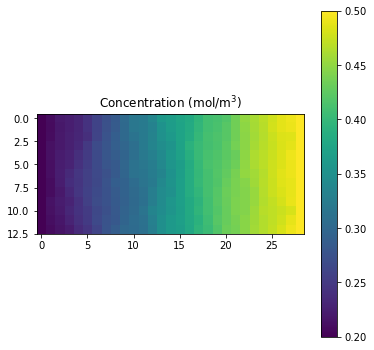

In [18]:
#NBVAL_IGNORE_OUTPUT
import matplotlib.pyplot as plt
c = fd['pore.concentration'].reshape((net._shape))
fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(c[:,:,0])
plt.title('Concentration (mol/m$^3$)')
plt.colorbar();